**Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


**Change Directory to Working Directory**

In [2]:
import os
os.chdir('/content/gdrive/My Drive/132A/Project')
!ls

 16QAM		     LLRs_4QAM_10.png   loss_16QAM_15.png   loss_BPSK_20.png
 4QAM		     LLRs_4QAM_15.png   loss_4QAM_10.png    Mixed
 BPSK		     LLRs_4QAM_20.png   loss_4QAM_15.png    Parameters.gsheet
'BPSK Trash Data'    LLRs_BPSK_10.png   loss_4QAM_20.png    Plots
 LLRs_16QAM_10.png   LLRs_BPSK_15.png   loss_BPSK_10.png
 LLRs_16QAM_15.png   LLRs_BPSK_20.png   loss_BPSK_15.png


**Load and Preprocess MATLAB Data**

In [3]:
import numpy as np
import pandas as pd
import scipy.io as sio

def unison_shuffled_copies(a, b, c):
    assert (len(a) == len(b)) and (len(a) == len(c)) and (len(b) == len(c))
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

sym_r = []
sym_i = []
LLR   = []
for i in range(4):
  x = sio.loadmat('BPSK/Raw Data/15 dB/BPSK_sym_15_' + str(i+1) + '.mat')
  y = sio.loadmat('BPSK/Raw Data/15 dB/BPSK_LLR_15_' + str(i+1) + '.mat')
  x_d = x['z_BPSK']
  LLR_d = y['LLR_BPSK']
  sym_r.append(np.asarray(x_d.real.ravel()))
  sym_i.append(np.asarray(x_d.imag.ravel()))
  LLR.append(np.asarray(LLR_d.ravel()))
  sym_r[i] = sym_r[i].reshape(1,-1)
  sym_i[i] = sym_i[i].reshape(1,-1)
  LLR[i] = LLR[i].reshape(1,-1)
  sym_r[i][0], sym_i[i][0], LLR[i][0] = unison_shuffled_copies(sym_r[i][0], sym_i[i][0], LLR[i][0])
  
print(sym_i[0])
print(LLR[0])

[[ 0.96174275 -1.05516125  0.93403896 ...  1.16640623  1.08157585
  -1.1525716 ]]
[[ 121.65190494 -133.46851455  118.14762121 ...  147.54001468
   136.80972646 -145.79005673]]


**Neural Network Model Definition**

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Concatenate, BatchNormalization, Activation
from keras import optimizers
from keras.regularizers import l1

def llr_model():
    Nsym = 10000
    input1 = Input(shape=(Nsym, ))
    input2 = Input(shape=(Nsym, ))
    merged = Concatenate(axis=1)([input1, input2])

    dense1 = Dense(4096, kernel_initializer='truncated_normal', activation = 'relu')(merged)
    dropout1 = Dropout(0.1)(dense1)

    dense2 = Dense(2048, kernel_initializer='truncated_normal', activation = 'relu')(dropout1)
    dropout2 = Dropout(0.1)(dense2)

    dense3 = Dense (1024, kernel_initializer='truncated_normal', activation = 'relu')(dropout2)
    dropout3 = Dropout(0.2)(dense3)

    dense4 = Dense (512, kernel_initializer='truncated_normal', activation = 'relu')(dropout3)
    dropout4 = Dropout(0.4)(dense4)
    
    output = Dense (10000, kernel_initializer='truncated_normal', activation = 'linear')(dropout4)
    model = Model(inputs=[input1, input2], output = output)
  
    Adam=optimizers.Adam(lr=1.0, beta_1=0.9, beta_2=0.999, decay=0.99, amsgrad=False)
    model.compile(loss="mean_squared_logarithmic_error", optimizer = 'Adam', metrics = ["mean_squared_error"], target_tensors = None)
    
    return model

#print(model.metrics_names)

Using TensorFlow backend.


**Train and Evaluate Neural Network Model**

In [5]:
import keras
import matplotlib.pyplot as plt

batchsize = 2**7  # training batch size
snrdb = 5.0
nb_epochs = 50    # number of epochs to train on
model = llr_model()

print (model.summary())
history = model.fit([sym_r[0], sym_i[0]], LLR[0], batch_size=batchsize, epochs = 500, validation_data = ([sym_r[1], sym_i[1]], LLR[1]), shuffle=True)

# Show performance
score = model.evaluate([sym_r[2], sym_i[2]], LLR[2], steps = batchsize)
print(score)

fig = plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.legend()
fig.savefig("loss_BPSK_15.png")
plt.close(fig)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 20000)        0           input_1[0][0]                    
                                                                 input_2[0][0]                    
______________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1 samples, validate on 1 samples
Epoch 1/500





1/1 [==============================] - 10s 10s/step - loss: 9.0911 - mean_squared_error: 16412.6973 - val_loss: 9.2119 - val_mean_squared_error: 16310.7998
Epoch 2/500
1/1 [==============================] - 0s 121ms/step - loss: 9.3151 - mean_squared_error: 19101.9258 - val_loss: 9.1765 - val_mean_squared_error: 16344.1299
Epoch 3/500
1/1 [==============================] - 0s 117ms/step - loss: 9.3219 - mean_squared_error: 24626.9609 - val_loss: 9.1555 - val_mean_squared_error: 16379.5586
Epoch 4/500
1/1 [==============================] - 0s 118ms/step - loss: 8.9079 - mean_squared_error: 26966.3555 - val_loss: 9.1980 - val_mean_squared_error: 16419.0625
Epoch 5/500
1/1 [==============================] - 0s 117ms/step - loss: 8.7142 - mean_squared_error: 37071.2969 - val_loss: 9.2572 - val_mean_squared_error: 16460.0957
Epoch 6/500


**Plot True and NN LLRs**

1/1 [==============================] - 0s 53ms/step
[ 117.147125 -163.27121   122.54569  ...  157.35469   130.42265
 -105.73799 ]


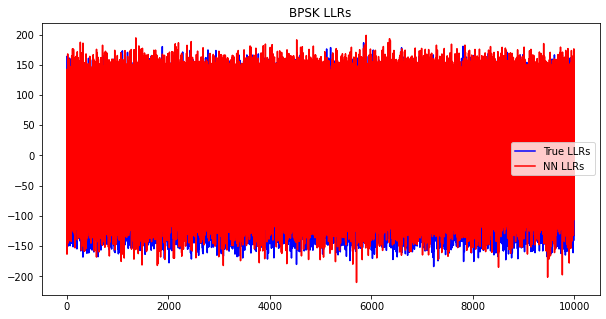

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
pred_llrs = model.predict([sym_r[3], sym_i[3]], verbose = 1, batch_size = None)
print (pred_llrs[0])
plt.plot(LLR[3][0], 'b', label = 'True LLRs')
plt.plot(pred_llrs[0], 'r', label = 'NN LLRs')
plt.title('BPSK LLRs')
plt.legend()
plt.show()
fig.savefig("LLRs_BPSK_15.png")

**Plot LLRs of Bit #0**

[ 117.147125 -163.27121   122.54569  ...  157.35469   130.42265
 -105.73799 ]
[ 114.34472308  109.47235417 -125.81649573 ...  127.61569965  114.97290977
 -120.37735027]


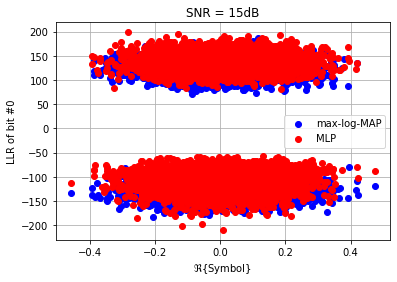

In [7]:
print(pred_llrs[0])
print(LLR[3][0])
fig2 = plt.figure()
plt.grid(True)
plt.scatter(sym_r[3], LLR[3], c='b', label = 'max-log-MAP',zorder=2)
plt.scatter(sym_r[3], pred_llrs[0], c='r', label = 'MLP',zorder=3)
plt.ylabel('LLR of bit #0')
plt.xlabel(r'$\Re$' + '{Symbol}')
plt.title('SNR = 15dB')
plt.legend()
fig2.savefig("Plots/BPSK_LLR_15.png")
plt.show()